https://www.kaggle.com/competitions/dogs-vs-cats/overview

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout ,Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3

In [5]:
IMAGE_WIDTH = 299 # для модели InceptionV3 размер нужен 299х299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 15
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
TRAIN_DIRECTORY = "big-files/train/"
TEST_DIRECTORY = "big-files/test/"

In [6]:
filenames = os.listdir(TRAIN_DIRECTORY)
test_directory = os.listdir(TEST_DIRECTORY)
    # Пути к оригинальным директориям

In [7]:
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)   

In [8]:
df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

test_df = pd.DataFrame({
    "filename": test_directory
})


<Axes: xlabel='category'>

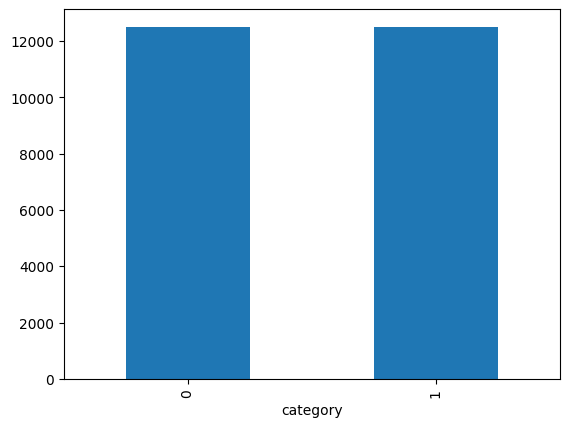

In [9]:
df["category"].value_counts().plot.bar()

In [10]:
model_conv = InceptionV3(weights="imagenet",
                   include_top = False,
                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

In [11]:
model_conv.trainable = False # замораживаем что бы не обучать слои

In [12]:
model = Sequential([
    model_conv,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid'),
])

In [13]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc"])

In [14]:
df['category'] = df['category'].astype(str)

In [15]:
# Изменяем размер всех изображений в папке до 250x250 пикселей
# for filename in os.listdir(source_folder):
#     img = Image.open(os.path.join(source_folder, filename))
#     img = img.resize((250, 250), Image.ANTIALIAS)  # Изменяем размер до 250x250
#     img.save(os.path.join(target_folder, filename))

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # для нормализации пикселей изображения в диапазоне [0, 1].
    rotation_range=20, # для легкой ротации изображения
    shear_range=0.2, # сдвиг угла
    zoom_range=0.2, # масштабирование
    horizontal_flip=True, # горизонтальный поворот
    vertical_flip=True, # вертикальный поворот
    width_shift_range=0.2, # сдвиг по горизонтали
    height_shift_range=0.2, # сдвиг по вертикали
    brightness_range=(0.8, 1.2), # изменение яркости
    validation_split = 0.2, # Разделение данных на обучающий и временный наборы (80% на обучение, 20% на валидацию)
    fill_mode='nearest', # для заполнения пикселей за пределами границ
)

test_datagen = ImageDataGenerator(
    rescale=1./255 # проверочнные данные не следует расширять
    ) 

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_DIRECTORY,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary',
    subset='training'  # Указываем, что это тренировочная часть
)

# Генератор данных для валидации
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_DIRECTORY,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary',
    subset='validation'  # Указываем, что это валидационная часть
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIRECTORY,
    x_col="filename",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


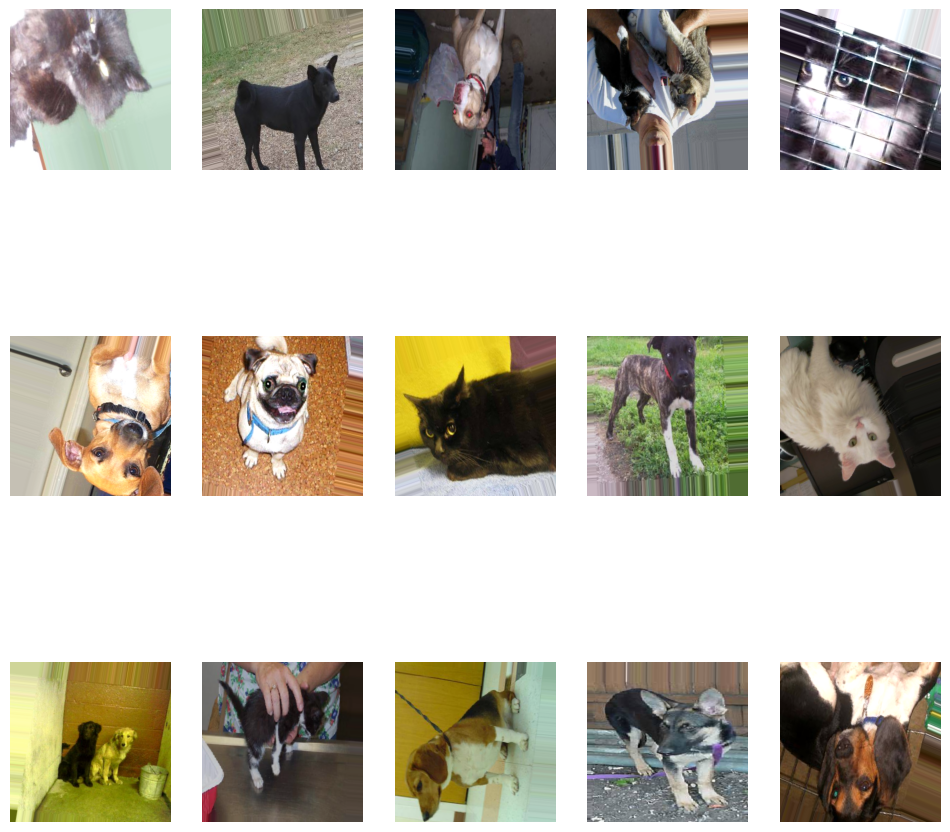

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(12, 12))  
for i in range(3):
    for j in range(5): # 3 строки и 5 столбцов для 15 изображений
        images, labels = next(train_generator)
        axes[i, j].imshow(images[0])
        axes[i, j].axis('off')

plt.show()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


earlystop = EarlyStopping(patience = 5)
    
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Хорошей практикой считается всегда сохранять модели после обучения.
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
)

Epoch 1/10


c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.6521 - loss: 17.6239 - val_acc: 0.8125 - val_loss: 9.1201
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.8922 - loss: 3.1000 - val_acc: 0.7578 - val_loss: 11.0885
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9324 - loss: 2.9418 - val_acc: 0.8984 - val_loss: 1.2677
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9022 - loss: 1.0673 - val_acc: 0.9219 - val_loss: 0.2288
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - acc: 0.9225 - loss: 0.2481 - val_acc: 0.9141 - val_loss: 0.1868
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9097 - loss: 0.1918 - val_acc: 0.9453 - val_loss: 0.1403
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9236 - loss: 0.1862 - val_acc: 0.8516 - val_loss: 0.2563
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9269 - loss: 0.1829 - val_acc: 0.9609 - val_loss: 0.0825
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.9301 - loss: 0.1740 - 

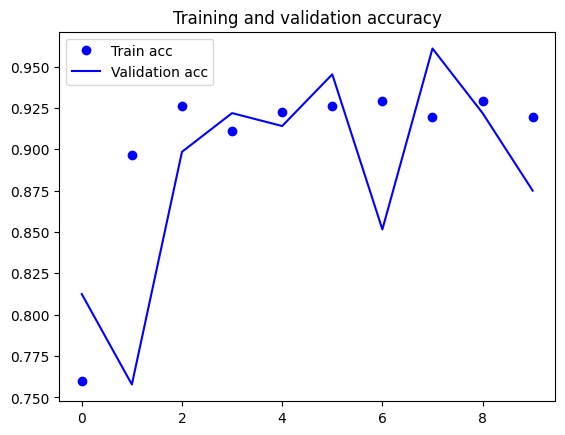

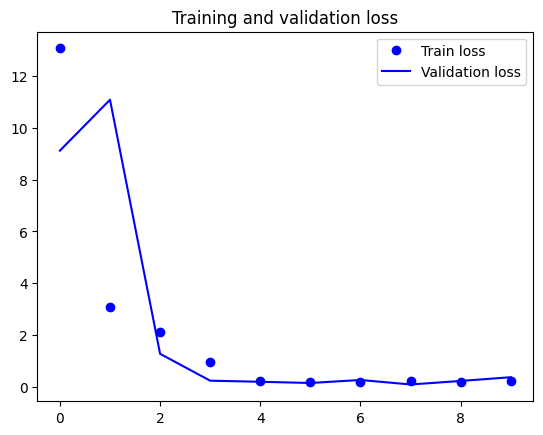

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [ ]:
pred = model.predict(test_generator)


391/391 ━━━━━━━━━━━━━━━━━━━━ 355s 903ms/step


In [ ]:
# res = np.argmax(pred, axis=1) # Выбираем класс с максимальной вероятностью (метка 1)
threshold = 0.5
res = (pred > threshold).astype(int) # Выбираем класс с максимальной вероятностью (метка 1)

In [ ]:
test_df["category"] = res


<Axes: xlabel='category'>

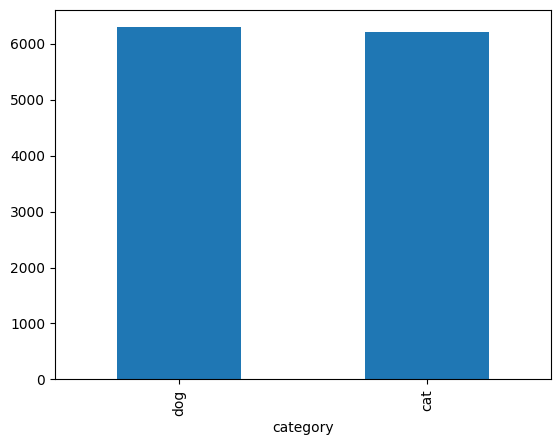

In [ ]:
test_df["category"] = test_df["category"].replace({0: "cat", 1: "dog"})
test_df["category"].value_counts().plot.bar()

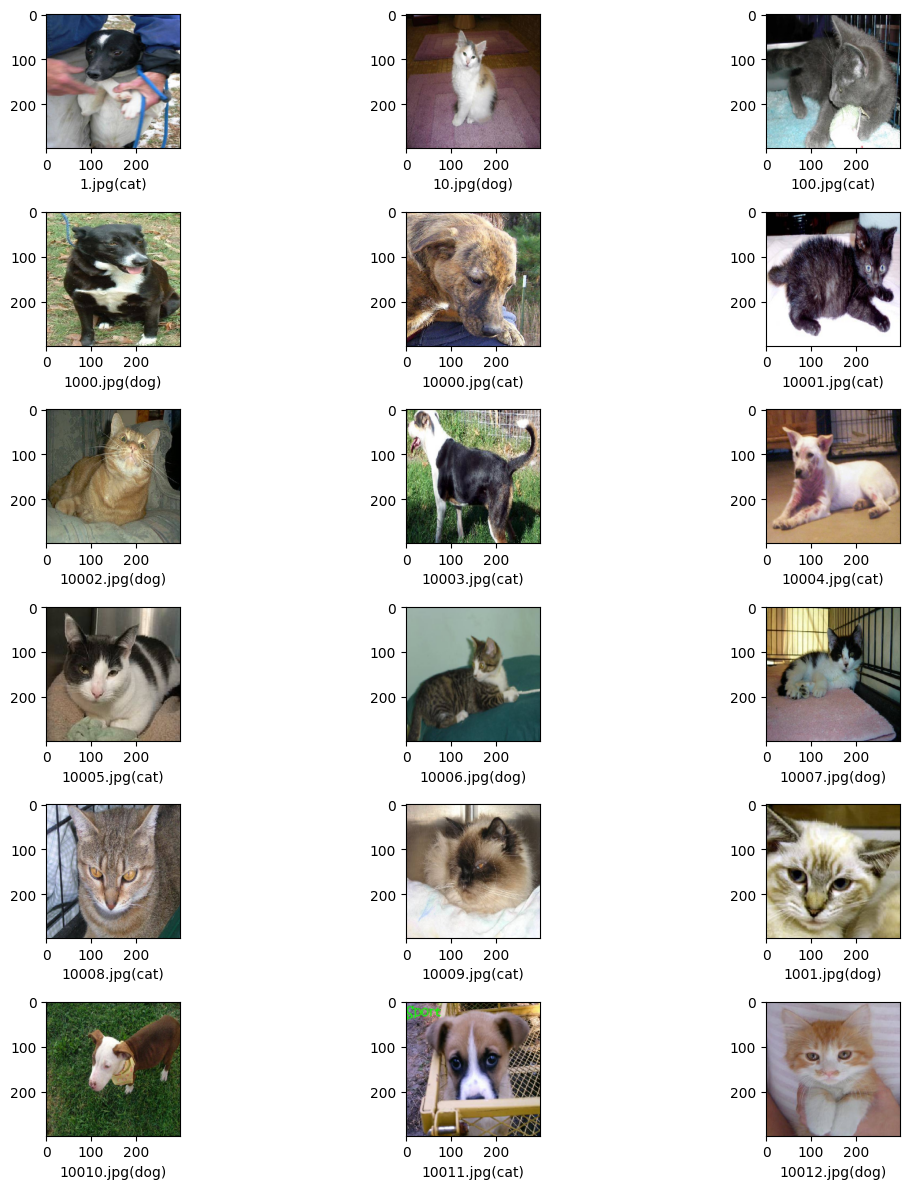

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img(TEST_DIRECTORY + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
res = pd.DataFrame(res)
res = res.rename(columns={0: 'label'})
res.to_csv("file.csv", index=False)

In [ ]:
red = pd.read_csv("file.csv")
red

,label
0,0
1,0
2,1
3,0
4,0
...,...
12495,1
12496,0
12497,1
12498,1
